In [0]:
#@title Copyright 2019 The Lifetime Value Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ============================================================================

# Churn Prediction for Kaggle Acquire Valued Customer Challenge

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/lifetime-value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/lifetime-value/blob/master/notebooks/kaggle_acquire_valued_shoppers_challenge/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
# from __future__ import google_type_annotations

import os

import numpy as np
import pandas as pd
import tqdm
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
!pip install -q git+https://github.com/google/lifetime-value
import lifetime_value as ltv

In [0]:
tfd = tfp.distributions
tf.enable_eager_execution()
pd.options.mode.chained_assignment = None  # default='warn'

## Global variables

In [0]:
COMPANY = '104900040'  # @param { isTemplate: true, type: 'string'}
LOSS = 'ziln'  # @param { isTemplate: true, type: 'string'} ['bce', 'ziln']
MODEL = 'linear'  # @param { isTemplate: true, type: 'string'} ['linear', 'dnn']
LEARNING_RATE = 0.0002  # @param { isTemplate: true}
EPOCHS = 400  # @param {type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/result'  # @param { isTemplate: true, type: 'string'}

In [0]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Data

### Download data

Setup kaggle API correctly following https://www.kaggle.com/docs/api

In [0]:
%%shell
if [ -e /tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv ]
then
  echo "File already exists, no need to download."
else
  rm -rf /tmp/lifetime-value/acquire-valued-shoppers-challenge
  mkdir /tmp/lifetime-value/acquire-valued-shoppers-challenge
  cd /tmp/lifetime-value/acquire-valued-shoppers-challenge
  kaggle competitions download -c acquire-valued-shoppers-challenge
  unzip acquire-valued-shoppers-challenge.zip
  gunzip transactions.csv.gz
fi

 99%|█████████▉| 2.85G/2.86G [01:03<00:00, 89.1MB/s]Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /usr/local/google/home/tianqiliu/.kaggle/kaggle.json'
100%|██████████| 2.86G/2.86G [01:04<00:00, 47.9MB/s]

Archive:  acquire-valued-shoppers-challenge.zip
  inflating: trainHistory.csv.gz     
  inflating: sampleSubmission.csv.gz  
  inflating: testHistory.csv.gz      
  inflating: offers.csv.gz           
  inflating: transactions.csv.gz     


### Load transaction csv

In [0]:
def load_transaction_data(company):
  all_data_filename = '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions.csv'
  one_company_data_filename = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/transactions_company_{}.csv'
      .format(COMPANY))
  if os.path.isfile(one_company_data_filename):
    df = pd.read_csv(one_company_data_filename)
  else:
    data_list = []
    chunksize = 10**6
    # 350 iterations
    for chunk in tqdm.tqdm(pd.read_csv(all_data_filename, chunksize=chunksize)):
      data_list.append(chunk.query("company=='{}'".format(company)))
    df = pd.concat(data_list, axis=0)
    df.to_csv(one_company_data_filename, index=None)
  return df

### Preprocess data

In [0]:
def preprocess(df):
  df = df.query('purchaseamount>0')
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
  df['start_date'] = df.groupby('id')['date'].transform('min')

  # Compute calibration values
  calibration_value = (
      df.query('date==start_date').groupby('id')
      ['purchaseamount'].sum().reset_index())
  calibration_value.columns = ['id', 'calibration_value']

  # Compute holdout values
  one_year_holdout_window_mask = (
      (df['date'] > df['start_date']) &
      (df['date'] <= df['start_date'] + np.timedelta64(365, 'D')))
  holdout_value = (
      df[one_year_holdout_window_mask].groupby('id')
      ['purchaseamount'].sum().reset_index())
  holdout_value.columns = ['id', 'holdout_value']

  # Compute calibration attributes
  calibration_attributes = (
      df.query('date==start_date').sort_values(
          'purchaseamount', ascending=False).groupby('id')[[
              'chain', 'dept', 'category', 'brand', 'productmeasure'
          ]].first().reset_index())

  # Merge dataframes
  customer_level_data = (
      calibration_value.merge(calibration_attributes, how='left',
                              on='id').merge(
                                  holdout_value, how='left', on='id'))
  customer_level_data['holdout_value'] = (
      customer_level_data['holdout_value'].fillna(0.))
  customer_level_data[CATEGORICAL_FEATURES] = (
      customer_level_data[CATEGORICAL_FEATURES].fillna('UNKNOWN'))

  # Specify data types
  customer_level_data['log_calibration_value'] = (
      np.log(customer_level_data['calibration_value']).astype('float32'))
  customer_level_data['chain'] = (
      customer_level_data['chain'].astype('category'))
  customer_level_data['dept'] = (customer_level_data['dept'].astype('category'))
  customer_level_data['brand'] = (
      customer_level_data['brand'].astype('category'))
  customer_level_data['category'] = (
      customer_level_data['category'].astype('category'))
  customer_level_data['label'] = (
      customer_level_data['holdout_value'].astype('float32'))
  return customer_level_data

### Load customer-level csv

In [0]:
def load_customer_level_csv(company):
  customer_level_data_file = (
      '/tmp/lifetime-value/acquire-valued-shoppers-challenge/customer_level_data_company_{}.csv'
      .format(company))
  if os.path.isfile(customer_level_data_file):
    customer_level_data = pd.read_csv(customer_level_data_file)
  else:
    customer_level_data = preprocess(load_transaction_data(company))
  for cat_col in CATEGORICAL_FEATURES:
    customer_level_data[cat_col] = (
        customer_level_data[cat_col].astype('category'))
  for num_col in [
      'log_calibration_value', 'calibration_value', 'holdout_value'
  ]:
    customer_level_data[num_col] = (
        customer_level_data[num_col].astype('float32'))

  return customer_level_data

In [0]:
customer_level_data = load_customer_level_csv(COMPANY)

We observe a mixture of zero and lognormal distribution of holdout value.

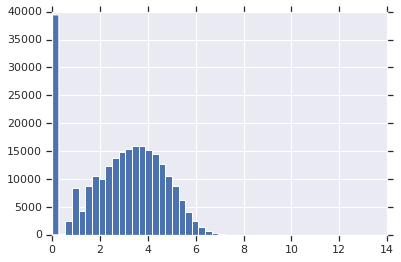

In [0]:
customer_level_data.label.apply(np.log1p).hist(bins=50)

In [0]:
customer_level_data.head().T

,0,1,2,3,4
id,86246,86252,12262064,12277270,12332190
calibration_value,11.58,0.99,1.72,4.49,1.49
chain,205,205,95,95,95
dept,36,21,21,36,36
category,3630,2105,2105,3601,3611
brand,23359,14357,14357,3809,4599
productmeasure,OZ,OZ,OZ,OZ,OZ
holdout_value,358.26,336.65,32.31,186.75,53.61
log_calibration_value,2.44928,-0.0100503,0.542324,1.50185,0.398776
label,358.26,336.65,32.31,186.75,53.61


## Data

### Make train/eval

In [0]:
def linear_split(df):
  # get_dummies preserves numeric features.
  x = pd.get_dummies(df[ALL_FEATURES], drop_first=True).astype('float32').values
  y = df['label'].values

  x_train, x_eval, y_train, y_eval = model_selection.train_test_split(
      x, y, test_size=0.2, random_state=123)

  return x_train, x_eval, y_train, y_eval

In [0]:
def dnn_split(df):
  for key in CATEGORICAL_FEATURES:
    encoder = preprocessing.LabelEncoder()
    df[key] = encoder.fit_transform(df[key])

  df_train, df_eval = model_selection.train_test_split(
      df, test_size=0.2, random_state=123)

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].values
    return features

  x_train, y_train = feature_dict(df_train), df_train['label'].values
  x_eval, y_eval = feature_dict(df_eval), df_eval['label'].values

  return x_train, x_eval, y_train, y_eval

## Model

In [0]:
def linear_model(output_units):
  return tf.keras.experimental.LinearModel(output_units)

In [0]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units, df):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].nunique())(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

### Loss

In [0]:
def zero_inflated_lognormal_loss(labels: tf.Tensor,
                                 logits: tf.Tensor) -> tf.Tensor:
  """Computes the zero inflated lognormal loss.

  Usage with tf.keras API:

  ```python
  model = tf.keras.Model(inputs, outputs)
  model.compile('sgd', loss=zero_inflated_lognormal)
  ```

  Arguments:
    labels: True targets, tensor of shape [batch_size, 1].
    logits: Logits of output layer, tensor of shape [batch_size, 3].

  Returns:
    Zero inflated lognormal loss value.
  """
  labels = tf.convert_to_tensor(labels, dtype=tf.float32)
  positive = tf.cast(labels > 0, tf.float32)

  logits = tf.convert_to_tensor(logits, dtype=tf.float32)
  logits.shape.assert_is_compatible_with(
      tf.TensorShape(labels.shape[:-1].as_list() + [3]))

  positive_logits = logits[..., :1]
  classification_loss = tf.keras.losses.binary_crossentropy(
      y_true=positive, y_pred=positive_logits, from_logits=True)

  loc = logits[..., 1:2]
  scale = K.softplus(logits[..., 2:])
  safe_labels = positive * labels + (1 - positive) * K.ones_like(labels)
  regression_loss = -K.mean(
      positive * tfd.LogNormal(loc=loc, scale=scale).log_prob(safe_labels),
      axis=-1)

  return classification_loss + regression_loss

### Train

In [0]:
if LOSS == 'bce':
  loss = keras.losses.BinaryCrossentropy(from_logits=True)
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [0]:
if MODEL == 'linear':
  x_train, x_eval, y_train, y_eval = linear_split(customer_level_data)
  model = linear_model(output_units)

if MODEL == 'dnn':
  x_train, x_eval, y_train, y_eval = dnn_split(customer_level_data)
  model = dnn_model(output_units, customer_level_data)

In [0]:
if LOSS == 'bce':
  y_train = (y_train > 0).astype('float32')
  y_eval = (y_eval > 0).astype('float32')

In [0]:
model.compile(loss=loss, optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [0]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [0]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=1024,
    epochs=EPOCHS,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Train on 199428 samples, validate on 49857 samples
Epoch 1/400
199428/199428 - 1s - loss: 18.0561 - val_loss: 15.2577
Epoch 2/400
199428/199428 - 1s - loss: 13.3657 - val_loss: 11.9011
Epoch 3/400
199428/199428 - 1s - loss: 10.7903 - val_loss: 9.9213
Epoch 4/400
199428/199428 - 1s - loss: 9.2033 - val_loss: 8.6430
Epoch 5/400
199428/199428 - 1s - loss: 8.1475 - val_loss: 7.7657
Epoch 6/400
199428/199428 - 1s - loss: 7.4057 - val_loss: 7.1342
Epoch 7/400
199428/199428 - 1s - loss: 6.8629 - val_loss: 6.6641
Epoch 8/400
199428/199428 - 1s - loss: 6.4531 - val_loss: 6.3038
Epoch 9/400
199428/199428 - 1s - loss: 6.1359 - val_loss: 6.0220
Epoch 10/400
199428/199428 - 1s - loss: 5.8853 - val_loss: 5.7972
Epoch 11/400
199428/199428 - 1s - loss: 5.6839 - val_loss: 5.6152
Epoch 12/400
199428/199428 - 1s - loss: 5.5198 - val_loss: 5.4656
Epoch 13/400
199428/199428 - 1s - loss: 5.3844 - val_loss: 5.3417
Epoch 14/400
199428/199428 - 1s - loss: 5.2715 - val_loss: 5.2380
Epoch 15/400
199428/199428 - 

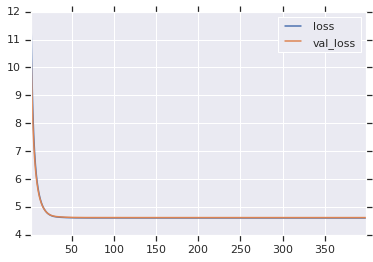

In [0]:
pd.DataFrame(history)[['loss', 'val_loss']][2:].plot()

### Eval

In [0]:
logits = model.predict(x=x_eval, batch_size=1024)
y_pred = K.sigmoid(logits[..., :1]).numpy().flatten()

In [0]:
y_true = (y_eval > 0).astype('float32')

In [0]:
def classification_report(y_true: Sequence[int],
                          y_pred: Sequence[float]) -> pd.DataFrame:
  """Report individual level classification metrics.

  Arguments:
    y_true: true binary labels.
    y_pred: predicted binary labels.

  Returns:
    out: dataframe with classification metrics as columns.
  """
  out = pd.DataFrame(index=[0])

  out['AUC'] = metrics.roc_auc_score(y_true, y_pred)
  out['PR_AUC'] = metrics.average_precision_score(y_true, y_pred)
  out['precision'] = metrics.precision_score(y_true, 1 * (y_pred > .5))
  out['recall'] = metrics.recall_score(y_true, 1 * (y_pred > .5))
  out['f1'] = metrics.f1_score(y_true, 1 * (y_pred > .5))
  return out

In [0]:
classification = classification_report(y_true, y_pred)
classification

,AUC,PR_AUC,precision,recall,f1
0,0.657588,0.906241,0.845141,0.998313,0.915364


### All metrics together

In [0]:
df_metrics = pd.DataFrame(
    {
        'company': COMPANY,
        'model': MODEL,
        'loss': LOSS,
        'label_mean': y_true.mean(),
        'pred_mean': y_pred.mean(),
        'AUC': classification.loc[0, 'AUC'],
        'PR_AUC': classification.loc[0, 'PR_AUC'],
        'precision': classification.loc[0, 'precision'],
        'recall': classification.loc[0, 'recall'],
        'f1': classification.loc[0, 'f1']
    },
    index=[0])

In [0]:
df_metrics[[
    'company',
    'model',
    'loss',
    'label_mean',
    'pred_mean',
    'AUC',
    'PR_AUC',
    'precision',
    'recall',
    'f1',
]]

,company,model,loss,label_mean,pred_mean,AUC,PR_AUC,precision,recall,f1
0,104900040,linear,ziln,0.844395,0.84196,0.657588,0.906241,0.845141,0.998313,0.915364


## Save

In [0]:
output_path = os.path.join(OUTPUT_CSV_FOLDER, COMPANY)

In [0]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [0]:
output_file = os.path.join(output_path,
                           '{}_classification_{}.csv'.format(MODEL, LOSS))

In [0]:
df_metrics.to_csv(output_file, index=False)